## Computer Vision for License Plate Recognition Challenge
> ### Use computer vision to detect and recognise Tunisian vehicle license plates
> - Author: Hamza Azizi
> - Date: January 2023
>
> In this notebook we propose an object detection and
recognition methodology applied to *License Plate Recognition
Challenge*.
> This challenge was designed specifically for the AI Tunisia Hack 2019, which took place from 20 to 22 September.\
> The link to the challenge is provided [here](https://zindi.africa/competitions/ai-hack-tunisia-2-computer-vision-challenge-2)

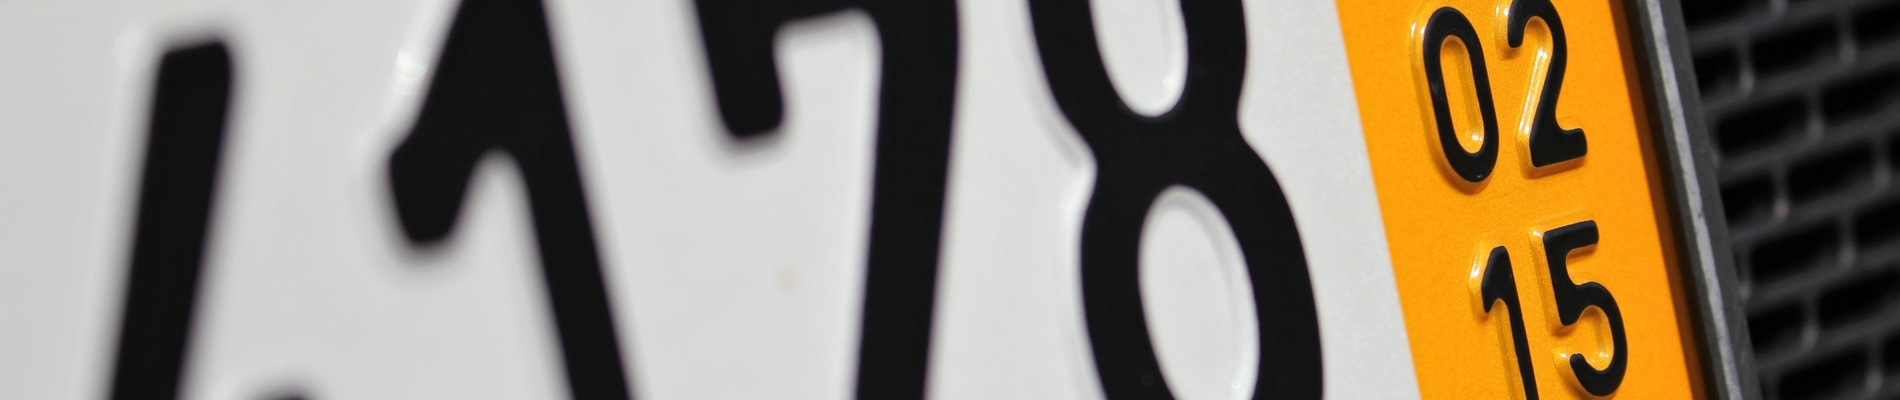



---



# Getting Data Via API From Zindi

In [1]:
# import requests , os
# import requests, zipfile

#the url and auth_value from the website 
# urls = ["https://api.zindi.africa/v1/competitions/ai-hack-tunisia-2-computer-vision-challenge-2/files/license_plates_detection_train.zip",
        # "https://api.zindi.africa/v1/competitions/ai-hack-tunisia-2-computer-vision-challenge-2/files/license_plates_recognition_train.zip",
        # "https://api.zindi.africa/v1/competitions/ai-hack-tunisia-2-computer-vision-challenge-2/files/test.zip"
#       ]
# myobj = {'auth_token': 'nSSrHdb6YXqcGU4tozJ2jWX5'} #use your own

# for url in urls :
#   x = requests.post(url, data = myobj,stream=True)
#   target_path = f"{url.split('/')[7].split('.')[0]}.zip"

#   handle = open(target_path, "wb")
#   for chunk in x.iter_content(chunk_size=512):
#       if chunk:   filter out keep-alive new chunks
        #   handle.write(chunk)
#   handle.close()

#   os.system(f"unzip -q {target_path}")

In [2]:
#the url and auth_value from the website 
# urls = ["https://api.zindi.africa/v1/competitions/ai-hack-tunisia-2-computer-vision-challenge-2/files/license_plates_detection_train.csv",
        # "https://api.zindi.africa/v1/competitions/ai-hack-tunisia-2-computer-vision-challenge-2/files/license_plates_recognition_train.csv"
        # ]
# myobj = {'auth_token': 'nSSrHdb6YXqcGU4tozJ2jWX5'} use your own

# for url in urls :
#   x = requests.post(url, data = myobj,stream=True)
#   target_path = f"{url.split('/')[7].split('.')[0]}.csv"

#   handle = open(target_path, "wb")
#   for chunk in x.iter_content(chunk_size=512):
#       if chunk:  filter out keep-alive new chunks
        #   handle.write(chunk)
#   handle.close()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras_preprocessing.image import ImageDataGenerator


In [3]:
df_detect = pd.read_csv("license_plates_detection_train.csv")
df_recogn = pd.read_csv("license_plates_recognition_train.csv")

In [4]:
df_detect = df_detect[['img_id','xmin','xmax','ymin','ymax']]

In [5]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("license_plates_detection_train/" + df_detect["img_id"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df_detect["xmax"].iloc[index] )
    ty = int(df_detect["ymax"].iloc[index] )
    bx = int(df_detect["xmin"].iloc[index] )
    by = int(df_detect["ymin"].iloc[index] )

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    
    plt.show()

# Some images from the training set

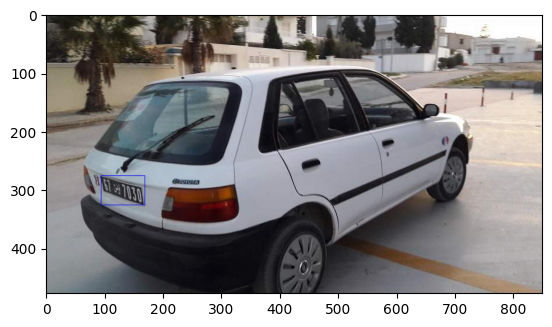

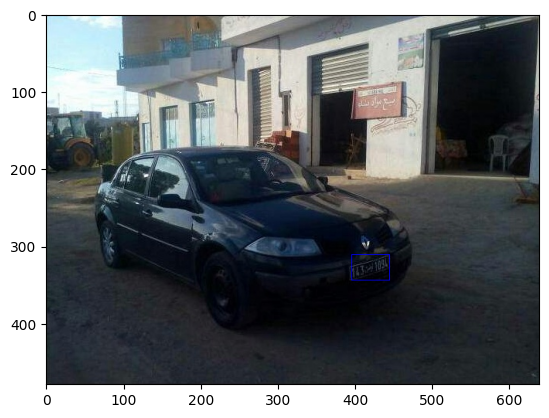

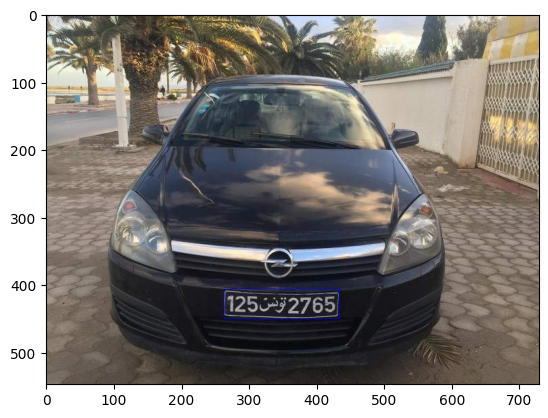

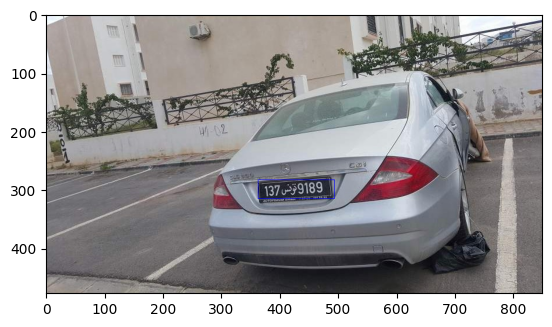

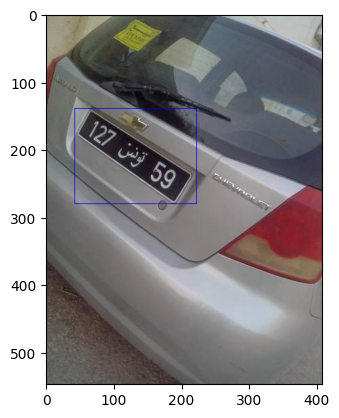

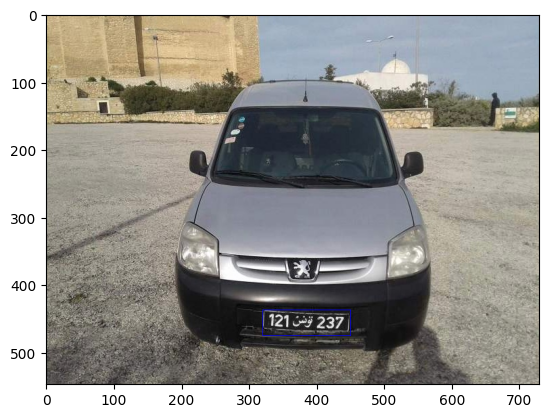

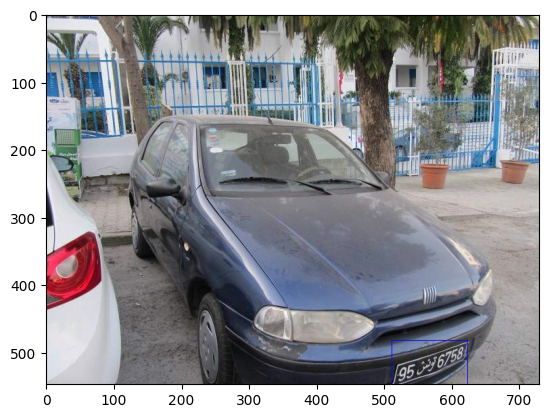

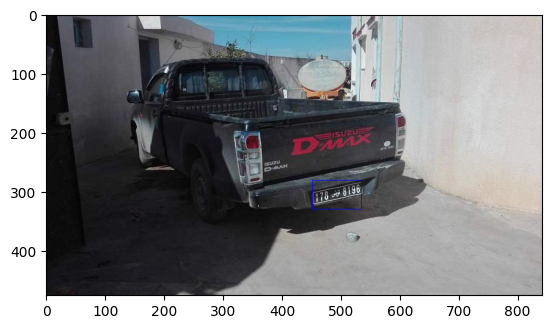

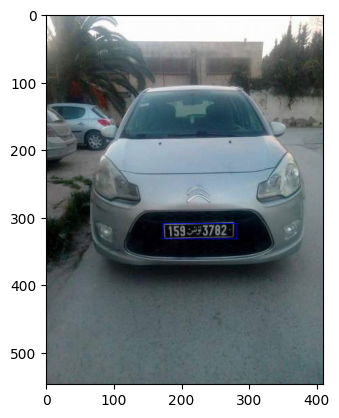

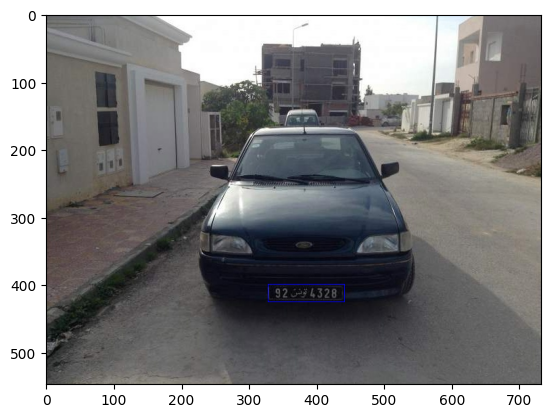

In [6]:
%matplotlib inline
for i in range(10):
  show_img(i)

In [7]:
import urllib
import matplotlib.pyplot as plt

import glob

import time
from PIL import Image

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications import InceptionResNetV2
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential

from keras.optimizers import Adam

from keras.optimizers import RMSprop
import os
import tensorflow as tf
#import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt


from glob import glob
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array


### Using Image Data Generator 

In [9]:
# Rescaling Data
df_norm = pd.DataFrame(columns = ['nxmin','nxmax','nymin','nymax'])
for i in range(len(df_detect)):
  image = "license_plates_detection_train/" + df_detect.iloc[i]["img_id"]
  img_arr = cv2.imread(image)
  h,w,d = img_arr.shape

  ymax = df_detect.iloc[i]["ymax"]
  ymin = df_detect.iloc[i]["ymin"]
  xmax = df_detect.iloc[i]["xmax"]
  xmin = df_detect.iloc[i]["xmin"]
  df_norm.loc[len(df_norm)] = [xmin/w, xmax/w, ymin/h, ymax/h]
df_detect = pd.concat([df_detect,df_norm], axis = 1)

In [10]:
# Rescaling Data
df_norm = pd.DataFrame(columns=['nxmin', 'nxmax', 'nymin', 'nymax'])
for i in range(len(df_detect)):
    # Construct the file path using the image number (assuming images are numbered from 1)
    img_filename = str(i + 1) + ".jpg"  # Adjust the file extension if necessary
    img_path = "license_plates_detection_train/" + img_filename
    img_arr = cv2.imread(img_path)

    # Check if the image was successfully loaded
    if img_arr is None:
        print(f"Error: Unable to load image {img_path}")
        continue

    h, w, d = img_arr.shape

    ymax = df_detect.iloc[i]["ymax"]
    ymin = df_detect.iloc[i]["ymin"]
    xmax = df_detect.iloc[i]["xmax"]
    xmin = df_detect.iloc[i]["xmin"]
    df_norm.loc[len(df_norm)] = [xmin / w, xmax / w, ymin / h, ymax / h]

df_detect = pd.concat([df_detect, df_norm], axis=1)


In [11]:
df_detect

img_id  xmin  xmax  ymin  ymax     nxmin     nxmax     nymin     nymax  \
0      1.jpg    94   169   276   326  0.110588  0.198824  0.578616  0.683438   
1     10.jpg   395   444   311   344  1.286645  1.446254  0.568556  0.628885   
2    100.jpg   263   434   406   450  0.360768  0.595336  0.742230  0.822669   
3    101.jpg   363   494   283   315  1.011142  1.376045  0.590814  0.657620   
4    102.jpg    42   222   139   280  0.051157  0.270402  0.254113  0.511883   
..       ...   ...   ...   ...   ...       ...       ...       ...       ...   
895   95.jpg    34   140   426   508  0.040000  0.164706  0.893082  1.064990   
896   96.jpg   378   548   356   457  1.231270  1.785016  0.650823  0.835466   
897   97.jpg   149   217   229   283  0.204390  0.297668  0.418647  0.517367   
898   98.jpg   252   383   272   300  0.614634  0.934146  0.497258  0.548446   
899   99.jpg   503   569    53   217  0.689986  0.780521  0.096892  0.396709   

        nxmin     nxmax     nymin     nymax     nxmin     nxmax     nymin  \
0    0.110588  0.198824  0.578616  0.683438  0.110588  0.198824  0.578616   
1    0.618153  0.694836  0.649269  0.718163  1.286645  1.446254  0.568556   
2    0.360768  0.595336  0.742230  0.822669  0.360768  0.595336  0.742230   
3    0.427059  0.581176  0.593291  0.660377  1.011142  1.376045  0.590814   
4    0.102689  0.542787  0.254113  0.511883  0.051157  0.270402  0.254113   
..        ...       ...       ...       ...       ...       ...       ...   
895  0.046639  0.192044  0.778793  0.928702  0.040000  0.164706  0.893082   
896  0.518519  0.751715  0.650823  0.835466  1.231270  1.785016  0.650823   
897  0.175294  0.255294  0.503297  0.621978  0.204390  0.297668  0.418647   
898  0.380090  0.577677  0.497258  0.548446  0.614634  0.934146  0.497258   
899  0.689986  0.780521  0.096892  0.396709  0.689986  0.780521  0.096892   

        nymax  
0    0.683438  
1    0.628885  
2    0.822669  
3    0.657620  
4    0.511883  
..        ...  
895  1.064990  
896  0.835466  
897  0.517367  
898  0.548446  
899  0.396709  

[900 rows x 17 columns]

In [12]:
IMAGE_SIZE = 224
batch_size = 64
datagen = ImageDataGenerator(validation_split = 0.1)

train_ds = datagen.flow_from_dataframe(
    df_detect,
    directory="license_plates_detection_train",
    x_col="img_id",
    y_col=['nxmin','nxmax','nymin','nymax'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = batch_size,
    class_mode = "other",
    subset="training")

val_ds = datagen.flow_from_dataframe(
    df_detect,
    directory = "license_plates_detection_train",
    x_col = "img_id",
    y_col = ['nxmin','nxmax','nymin','nymax'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = batch_size,
    class_mode = "other",
    subset = "validation")

Found 810 validated image filenames.
Found 90 validated image filenames.


### Without Image Data Generator

In [13]:
df_detect = pd.read_csv("license_plates_detection_train.csv")

df_detect = df_detect[['img_id','xmin','xmax','ymin','ymax']]
labels = df_detect.iloc[:,1:].values
data = []
output = []
images_path = list(df_detect["img_id"])
for i in range(len(df_detect)) :
    image = "license_plates_detection_train/" + df_detect.iloc[i]["img_id"]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[i]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)


# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((720, 224, 224, 3), (180, 224, 224, 3), (720, 4), (180, 4))

## Model From Scratch

In [14]:
model = Sequential()

# Convolutional Layers

model.add(Conv2D(128 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64 , (3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16 , (3,3),activation='relu'))
model.add(MaxPooling2D())



# Full Connected Layers

model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="sigmoid"))


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(8, activation='relu'),  # Modify this line to have 8 units
    Dense(4)  # Output layer with 4 units
])

model.compile(optimizer='adam', loss='mse')  # Example compilation, adjust as needed


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
EPOCH = 100

lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

## Model Architecture

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 16)        9232      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 16)       

In [18]:
'''from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4)  # Output layer with 4 units for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # MSE loss for regression task

# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

# Display model summary
model.summary()

# Train the model
history = model.fit(train_ds, batch_size=batch_size, epochs=EPOCH, validation_data=val_ds, callbacks=[early_stop, lr_reduction])'''


"from keras.models import Sequential\nfrom keras.layers import Conv2D, MaxPooling2D, Flatten, Dense\nfrom tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping\n\n# Define the model\nmodel = Sequential([\n    Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),\n    MaxPooling2D((2, 2)),\n    Conv2D(64, (3, 3), activation='relu'),\n    MaxPooling2D((2, 2)),\n    Conv2D(16, (3, 3), activation='relu'),\n    MaxPooling2D((2, 2)),\n    Flatten(),\n    Dense(64, activation='relu'),\n    Dense(4)  # Output layer with 4 units for regression\n])\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='mse')  # MSE loss for regression task\n\n# Define callbacks\nlr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.4, min_lr=0.0001)\nearly_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)\n\n# Display model summary\nmodel.summary()\n\n# Train the model\nhistory = model.fi

Training Model With Image Data Generator

In [19]:
# history = model.fit(train_ds, batch_size = batch_size, epochs = EPOCH, validation_data = val_ds,callbacks=[early_stop,lr_reduction])

Training Model Without Image Data Generator

In [18]:
model = Sequential()

# Convolutional Layers

model.add(Conv2D(128 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64 , (3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16 , (3,3),activation='relu'))
model.add(MaxPooling2D())



# Full Connected Layers

model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="sigmoid"))


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [19]:
history = model.fit(x_train,y_train, batch_size = batch_size, epochs = 20, validation_data = (x_test,y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/20
12/12 [==============================] - 187s 11s/step - loss: 0.0246 - val_loss: 0.0216 - lr: 0.0010
Epoch 2/20
12/12 [==============================] - 157s 12s/step - loss: 0.0195 - val_loss: 0.0194 - lr: 0.0010
Epoch 3/20
12/12 [==============================] - 303s 26s/step - loss: 0.0163 - val_loss: 0.0160 - lr: 0.0010
Epoch 4/20
12/12 [==============================] - 174s 14s/step - loss: 0.0130 - val_loss: 0.0147 - lr: 0.0010
Epoch 5/20
12/12 [==============================] - 200s 17s/step - loss: 0.0106 - val_loss: 0.0138 - lr: 0.0010
Epoch 6/20
12/12 [==============================] - 173s 14s/step - loss: 0.0099 - val_loss: 0.0129 - lr: 0.0010
Epoch 7/20
12/12 [==============================] - 200s 17s/step - loss: 0.0090 - val_loss: 0.0133 - lr: 0.0010
Epoch 8/20
12/12 [==============================] - 129s 11s/step - loss: 0.0083 - val_loss: 0.0125 - lr: 0.0010
Epoch 9/20
12/12 [==============================] - 115s 9s/step - loss: 0.0077 - val_loss: 0.01

Training The Model Without Image Data Generator showed more efficiency

In [20]:
def plot_scores(history) :
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss Plot')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

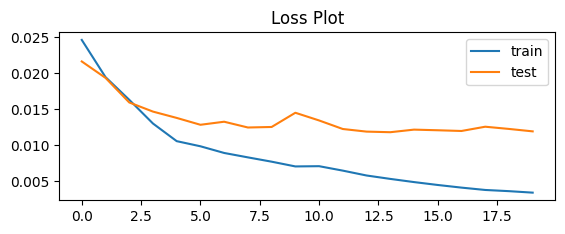

In [21]:
plot_scores(history)

We clearly can see a good learning rate in this loss plot almost the same validation loss and decreasing in time execpt the little gap from the 17th epoch




## Transfert Learning Model

### Resnet 50 

In [22]:
resnet = ResNet50(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# --------------------- 
headmodel = resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(1024,activation="relu")(headmodel)
headmodel = Dense(128,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# -------------------- model
model = Model(inputs = resnet.input, outputs = headmodel)

94765736/94765736 [==============================] - 122s 1us/step


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [24]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
history = model.fit(x_train,y_train, batch_size = 32, epochs = 10, validation_data = (x_test,y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/10
23/23 [==============================] - 514s 19s/step - loss: 0.1612 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 2/10
23/23 [==============================] - 440s 19s/step - loss: 0.1550 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 3/10
23/23 [==============================] - 487s 21s/step - loss: 0.1550 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 4/10
23/23 [==============================] - 373s 16s/step - loss: 0.1552 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 5/10
23/23 [==============================] - 315s 14s/step - loss: 0.1552 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 6/10
23/23 [==============================] - 385s 17s/step - loss: 0.1552 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 7/10
23/23 [==============================] - 352s 15s/step - loss: 0.1552 - val_loss: 0.1577 - lr: 1.0000e-04
Epoch 8/10


### VGG 16

In [ ]:
vgg16 = VGG16(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# --------------------- 
headmodel = vgg16.output
headmodel = Flatten()(headmodel)
headmodel = Dense(1024,activation="relu")(headmodel)
headmodel = Dense(128,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# -------------------- model
model = Model(inputs=vgg16.input,outputs=headmodel)

In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
history = model.fit(x_train,y_train, batch_size = 32, epochs = 10, validation_data = (x_test,y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/10
23/23 [==============================] - 12s 489ms/step - loss: 0.0232 - val_loss: 0.0171 - lr: 1.0000e-04
Epoch 2/10
23/23 [==============================] - 11s 477ms/step - loss: 0.0102 - val_loss: 0.0078 - lr: 1.0000e-04
Epoch 3/10
23/23 [==============================] - 11s 486ms/step - loss: 0.0052 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 4/10
23/23 [==============================] - 11s 486ms/step - loss: 0.0036 - val_loss: 0.0045 - lr: 1.0000e-04
Epoch 5/10
23/23 [==============================] - 11s 482ms/step - loss: 0.0023 - val_loss: 0.0039 - lr: 1.0000e-04
Epoch 6/10
23/23 [==============================] - 11s 477ms/step - loss: 0.0015 - val_loss: 0.0038 - lr: 1.0000e-04
Epoch 7/10
23/23 [==============================] - 11s 474ms/step - loss: 0.0010 - val_loss: 0.0025 - lr: 1.0000e-04
Epoch 8/10
23/23 [==============================] - 11s 474ms/step - loss: 8.1631e-04 - val_loss: 0.0025 - lr: 1.0000e-04
Epoch 9/10
23/23 [==============================] - 

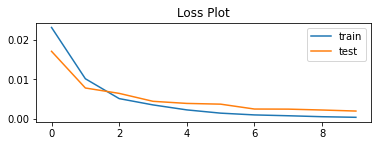

In [ ]:
plot_scores(history)

We clearly can see a better learning rate in this loss plot compared to the plot of the model from scratch,almost the same validation loss from the 4th epoch and decreasing in time to go stable from the 8th epoch.




# Saving the model in drive to use later for the recognition

In [ ]:
model.save('object_detection(best).h5')

## Loading Model From Drive

In [ ]:
from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model = tf.keras.models.load_model('object_detection(best).h5')

In [ ]:
def cropping_plate(path,cods):
  xmin, xmax, ymin, ymax = cods[0]
  box = (xmin, ymin, xmax, ymax)
  image = Image.open(path)
  img = image.crop(box)
  return(img)

1/1 [==============================] - 1s 979ms/step
(310, 423) (492, 458)



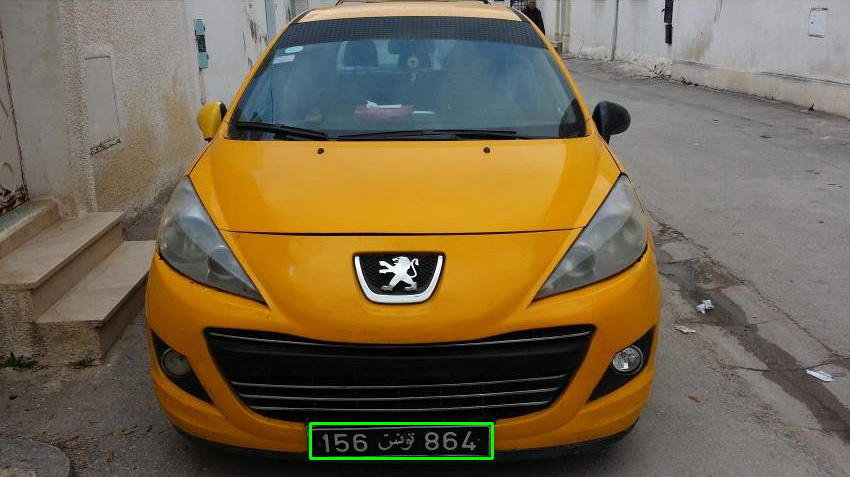

In [ ]:
# Create pipeline
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),2)
    return image, coords

path = 'test_private/1030.jpg'
image, cods = object_detection(path)
plate_img = cropping_plate(path,cods)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

# Plate Recognition

In [ ]:
def lot_images(image):
  #check if there is at least one license image
  from skimage import io
  import matplotlib.gridspec as gridspec

  #image = cv2.imread(path)
  # Scales, calculates absolute values, and converts the result to 8-bit.
  plate_image = cv2.convertScaleAbs(image)

  # convert to grayscale and blur the image
  gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(7,7),0)

  # Applied inversed thresh_binary 
  binary = cv2.threshold(blur, 180, 255,
                        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

      
  # visualize results    
  fig = plt.figure(figsize=(12,7))
  plt.rcParams.update({"font.size":18})
  grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
  plot_image = [plate_image, gray, blur, binary,thre_mor]
  plot_name = ["plate_image","gray","blur","binary","dilation"]

  for i in range(len(plot_image)):
      fig.add_subplot(grid[i])
      plt.axis(False)
      plt.title(plot_name[i])
      if i == 0:
          plt.imshow(plot_image[i])
      else:
          plt.imshow(plot_image[i],cmap="gray")
  return plot_image

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
import pytesseract
def draw_boxes(img):
  boxes = pytesseract.image_to_boxes(img,config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
  for b in boxes.splitlines():
    b = b.split(' ')
    hImg = img.shape[0]
    wImg = img.shape[1]
    x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
    cv2.rectangle(img, (x, hImg - y), (w, hImg - h), (50, 50, 255), 1)
    cv2.putText(img, b[0], (x, hImg - y + 13), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (50, 205, 50), 1)
  plt.imshow(img,cmap="gray")

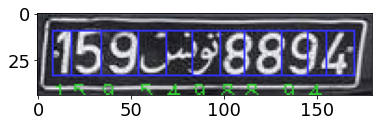

In [ ]:
path = "license_plates_recognition_train/99.jpg"
img = cv2.imread(path)
draw_boxes(img)

The issue with the pytesseract is recognises the word *Tunis* in numbers for this image its 549.\
To overcome this issue we will do some transformations on the image and apply the recognition function on each image the word *Tunis* will be recognised as a different number or a symbol.\
For the recognition we will be using the function image_to_string which will take an image input and returns a string with the numbers contained in the image,
then we will be taking the substrings of each string (output of the function image_to_string on each image), and take the common substrings which are the car plate numbers.


---

In the following section the pipeline to be going threw is explained:

This Function will take a string and return all the numerical substrings whose length is between 1 and 4

In [ ]:
def common_num(X):
  res = [X[i: j] for i in range(len(X))
            for j in range(i + 1, len(X) + 1)]
  hh = []
  for i in range(len(res)):
    if(res[i].isnumeric()) and (len(res[i]) < 5) and (len(res[i]) > 1):
      hh.append(res[i])
  return set(hh)


This Function will generate the 4 versions of the transformation on the image 

*   gray
*   blur
*   binary
*   dilation





In [ ]:
def generate(path):
  image = cv2.imread(path)
  plot_image = lot_images(image)
  return(plot_image)

This function will take the original image and the other 4 versions and apply the image_to_string function on each one of them.
Then will get all the substrings of each string generated by the function image_to_string in a set(each set belong to an image).
Then will take common substrings in each set.
Which will gives us the two numbers of the car plate

In [ ]:
def recog(path):
  plot_image = generate(path)
  l = []
  for i in range(len(plot_image)):
    l.append(pytesseract.image_to_string(plot_image[i],config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'))

  ens = []

  for e in l :
    if(common_num(e)):
      ens.append(common_num(e))
    
  if(len(ens)>0):  
    s = set.intersection(*ens)
    elmin = []
    for e in s:
      for e2 in s:
        if(e in e2 and e!=e2):
          elmin.append(e)
          break
    for x in elmin:
      h = s.remove(x)
    print(s)
  else:
    print("Can't Recognise The Plate")

{'159', '8894'}


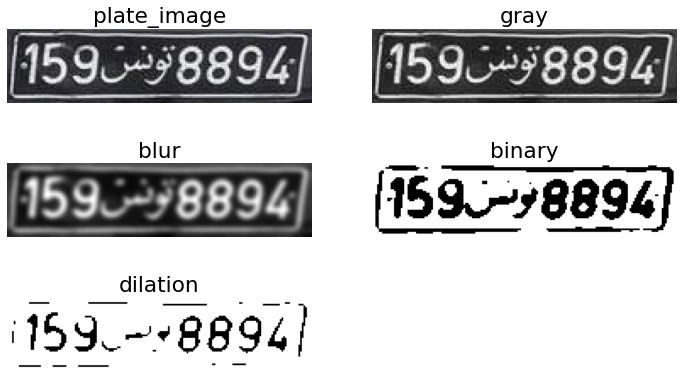

In [ ]:
path = "license_plates_recognition_train/99.jpg"
recog(path)

In [ ]:
import csv

# Predict the results and generate submission file
def generate_submission_file(model, image_paths, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header
        writer.writerow(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        
        # Predict for each image and write to CSV
        for path in image_paths:
            # Perform object detection and plate recognition
            # Replace this with your actual object detection and plate recognition code
            image, coords = object_detection(path)
            plate_img = cropping_plate(path, coords)
            plate_numbers = plate_recognition(plate_img)
            
            # Example: Generating dummy predictions for each image
            predictions = [0] * 10  # Dummy predictions, replace this with your actual predictions
            
            # Write predictions to CSV
            img_id = path.split('/')[-1]  # Extract image ID from the path
            row = [img_id] + predictions
            writer.writerow(row)

# Example usage
image_paths = ['path_to_image1.jpg', 'path_to_image2.jpg']  # Replace with your image paths
output_file = 'submission.csv'

# Call the function to generate the submission file
generate_submission_file(model, image_paths, output_file)
